In [1]:
import pandas as pd
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
from glob import glob
from matplotlib.patches import Patch
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, accuracy_score)

In [2]:
# load in and merge all matching files in the current directory
def load_all_files(pattern):
    files = glob(pattern)
    df_list = [pd.read_csv(f) for f in files]
    return pd.concat(df_list, ignore_index=True)

# load all files 
workouts = load_all_files('workouts*.csv')
sleeps = load_all_files('sleeps*.csv')
journal_entries = load_all_files('journal_entries*.csv')
physiological_cycles = load_all_files('physiological_cycles*.csv')

# pivot journal data starting with the cycle start time because it is the first column for each
journal_pivot = journal_entries.pivot_table(
    index='Cycle start time',
    columns='Question text',
    values='Answered yes',
    aggfunc='first'
).reset_index()

# merge all the files together
merged = physiological_cycles.merge(
    sleeps, on='Cycle start time', suffixes=('_physio', '_sleep'), how='outer')
merged = merged.merge(workouts, on='Cycle start time', how='outer')
merged = merged.merge(journal_pivot, on='Cycle start time', how='outer')

**Cleaning the Data:**

There is a lot of clean up to do with this data as this is data we collected and did not pull from an online data base like kaggle, where most of the data is already cleaned and ready to be used.

In [3]:
# drop rows with no sleep performance data, skin temp data, and blood oxygen data
merged_clean = merged.dropna(subset=['Sleep performance %_sleep','Skin temp (celsius)', 'Blood oxygen %'])

# columns to drop because there is no data/not relevant
columns_to_drop = [
    'Distance (meters)', 'Altitude gain (meters)', 'Altitude change (meters)',
    'Have an injury or wound', 'Read (non-screened device) while in bed?',
    'Share your bed?', 'Take prescription sleep medication?',
    'Viewed a screen device in bed?', 'GPS enabled',
    'Feeling sick or ill?', 'Have any alcoholic drinks?', 'Have any caffeine? ',
    'Cycle start time', 'Cycle end time_physio', 'Cycle timezone_physio',
    'Eat any food close to bedtime?', 'Slept in the same bed as usual','Snack in between meals?',
    'Spend time stretching?','Take creatine?', 'Take electrolyte supplements?','Took a cold shower',
    'Took a hot shower before bed', 'Tracked your calories', 'Watch the sunset?', 'Wore blue-light blocking glasses before bed',
    'Consumed protein?','Eat all your meals during daylight hours?','Experience bloating?',
    'Experiencing COVID-19 symptoms','Felt recovered?',
    'Hydrated sufficiently?','Receive booster of COVID-19 vaccination?','Receive dose #1 of COVID-19 vaccination?',
    'Receive dose #2 of COVID-19 vaccination?','Single?','Commute to work?',
    'Consume added sugar?','Consume dairy?','Sleep consistency %_physio','Sleep consistency %_sleep',
    'Consume fruits and/or vegetables?','Consume meat?','Workout start time',
    'Workout end time','Cycle end time_sleep','Cycle timezone_sleep','Sleep onset_sleep','Wake onset_sleep','Cycle end time',
    'Cycle timezone']
merged_clean = merged_clean.drop(columns=columns_to_drop)

# because we combined the sleep and physio csv files, we must drop these duplicates with a slightly different name
sleep_dupes = [col for col in merged_clean.columns if col.endswith('_physio')]
merged_clean = merged_clean.drop(columns=sleep_dupes)

# Rename columns: remove '_sleep' suffix
merged_clean = merged_clean.rename(columns={col: col.replace('_sleep', '') for col in merged_clean.columns if col.endswith('_sleep')})

# fill missing HR with resting HR
for col in ['Average HR (bpm)_y', 'Max HR (bpm)_y']:
    merged_clean[col] = merged_clean.apply(
        lambda row: row['Resting heart rate (bpm)'] if pd.isna(row[col]) else row[col],
        axis=1)
    
# drop rows with no data on Skin temp, Energy burned (cal)_x, Day Strain, Max HR (bpm)_x, Average HR (bpm)_x 
# and Blood oxygen because there are very few missing rows (4-5 for each)
merged_clean = merged_clean.dropna(subset=['Skin temp (celsius)', 'Blood oxygen %', 'Max HR (bpm)_x',
                                          'Energy burned (cal)_x', 'Day Strain','Average HR (bpm)_x'])

# change "Duration (min)" to Activity Duration for consistency
merged_clean = merged_clean.rename(columns={'Duration (min)': 'Activity Duration (min)'})

# rename columns to be more clear, x is from workout csv and y just total
merged_clean = merged_clean.rename(columns={
    'Max HR (bpm)_x': 'Workout Max HR (bpm)',
    'Average HR (bpm)_x': 'Workout Avg HR (bpm)',
    'Max HR (bpm)_y': 'Daily Max HR (bpm)',
    'Average HR (bpm)_y': 'Daily Avg HR (bpm)',
    'Energy burned (cal)_x': 'Workout Calories Burned',
    'Energy burned (cal)_y': 'Daily Calories Burned'})


# fill missing activity stats with 0
merged_clean[['Activity Strain', 'Daily Calories Burned', 'Activity Duration (min)']] = merged_clean[
    ['Activity Strain', 'Daily Calories Burned', 'Activity Duration (min)']
].fillna(0)

# fill HR zones with 0 if empty, indicating these were not hit or no ativity was done
hr_zones = ['HR Zone 1 %', 'HR Zone 2 %', 'HR Zone 3 %', 'HR Zone 4 %', 'HR Zone 5 %']
merged_clean[hr_zones] = merged_clean[hr_zones].fillna(0)

# if no activity happened, label as 'None'
merged_clean['Activity name'] = merged_clean['Activity name'].fillna('None')

# drop naps
if 'Nap' in merged_clean.columns:
    merged_clean = merged_clean[merged_clean['Nap'] != True]
merged_clean = merged_clean.drop(columns='Nap')

# save to new file
merged_clean.to_csv('merged_dataset.csv', index=False)

# preview
merged_clean.head(20)

,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Skin temp (celsius),Blood oxygen %,Day Strain,Workout Calories Burned,Workout Max HR (bpm),Workout Avg HR (bpm),Sleep performance %,...,Activity name,Activity Strain,Daily Calories Burned,Daily Max HR (bpm),Daily Avg HR (bpm),HR Zone 1 %,HR Zone 2 %,HR Zone 3 %,HR Zone 4 %,HR Zone 5 %
106,34.0,66.0,40.0,33.13,98.00,16.8,3182.0,177.0,87.0,82.0,...,Lacrosse,15.4,1188.0,177.0,134.0,9.0,27.0,48.0,13.0,0.0
107,30.0,69.0,36.0,35.00,96.82,5.7,2024.0,129.0,77.0,73.0,...,None,0.0,0.0,69.0,69.0,0.0,0.0,0.0,0.0,0.0
108,42.0,64.0,50.0,34.90,96.60,14.4,2918.0,172.0,82.0,89.0,...,Functional Fitness,10.9,557.0,172.0,122.0,23.0,58.0,11.0,8.0,0.0
111,39.0,64.0,44.0,33.60,96.67,11.8,2379.0,175.0,82.0,100.0,...,Functional Fitness,9.6,399.0,175.0,114.0,54.0,24.0,7.0,8.0,0.0
112,26.0,64.0,41.0,33.90,94.14,17.6,3763.0,180.0,87.0,79.0,...,Basketball,12.7,483.0,180.0,145.0,0.0,40.0,26.0,26.0,8.0
113,26.0,64.0,41.0,33.90,94.14,17.6,3763.0,180.0,87.0,79.0,...,Functional Fitness,11.9,727.0,165.0,118.0,38.0,42.0,16.0,2.0,0.0
114,24.0,69.0,37.0,33.60,99.00,10.3,2129.0,156.0,81.0,51.0,...,None,0.0,0.0,69.0,69.0,0.0,0.0,0.0,0.0,0.0
115,1.0,76.0,25.0,34.79,92.71,12.9,2587.0,172.0,88.0,73.0,...,Lacrosse,10.6,469.0,168.0,135.0,4.0,37.0,48.0,11.0,0.0
116,11.0,74.0,26.0,33.90,96.93,6.5,2178.0,130.0,83.0,65.0,...,None,0.0,0.0,74.0,74.0,0.0,0.0,0.0,0.0,0.0
118,15.0,81.0,23.0,36.18,95.50,6.9,1777.0,141.0,85.0,68.0,...,None,0.0,0.0,81.0,81.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# find strongest correlations of variables, anything absolute value of .2
# get only numeric data
numeric_data = merged_clean.select_dtypes(include='number')

# create the correlation matrix
correlation_matrix = numeric_data.corr()

# get rid of all self-correlations by setting the diagonal line to 0
np.fill_diagonal(correlation_matrix.values, 0)

# fine the pairs with the highest correlation
strong_pairs = (correlation_matrix.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

# get rid duplicate feature pairs so they don't happen twice
strong_pairs['Ordered'] = strong_pairs.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1)
strong_pairs = strong_pairs.drop_duplicates('Ordered').drop(columns='Ordered')

# filter strong correlations
total_strong_pairs = strong_pairs[strong_pairs['Correlation'].abs() >= 0.6].sort_values(by='Correlation', ascending=False)
sleep_strong_pairs = strong_pairs[strong_pairs['Correlation'].abs() >= 0.4].sort_values(by='Correlation', ascending=False)

# sort alphabetically
strong_pairs_sorted = total_strong_pairs.sort_values(by=['Feature 1', 'Feature 2']).reset_index(drop=True)
strong_pairs_sorted


,Feature 1,Feature 2,Correlation
0,Activity Duration (min),Activity Strain,0.675288
1,Activity Duration (min),Daily Calories Burned,0.784833
2,Activity Strain,Daily Avg HR (bpm),0.851623
3,Activity Strain,Daily Calories Burned,0.847312
4,Activity Strain,Daily Max HR (bpm),0.898637
5,Asleep duration (min),In bed duration (min),0.980841
6,Asleep duration (min),Light sleep duration (min),0.715155
7,Awake duration (min),Sleep efficiency %,-0.870253
8,Daily Avg HR (bpm),HR Zone 3 %,0.639935
9,Daily Calories Burned,Daily Avg HR (bpm),0.632130


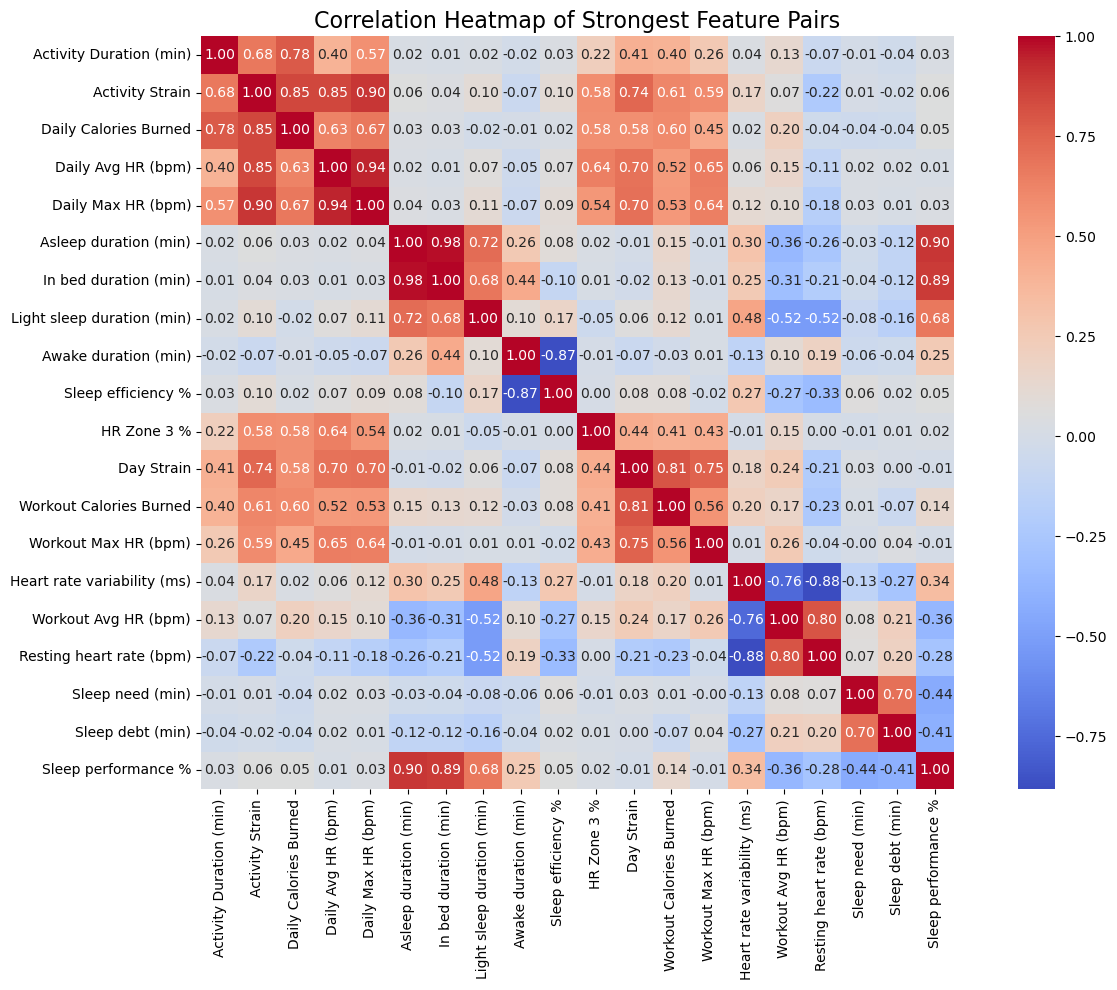

In [5]:
# plot the heatmap
# get unique features
top_features = pd.unique(strong_pairs_sorted[['Feature 1', 'Feature 2']].values.ravel())

# get the filtered correlation matrix
filtered_corr = merged_clean[top_features].corr()

# plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Heatmap of Strongest Feature Pairs', fontsize=16)
plt.tight_layout()
plt.show()

We now need to isolate only the correlations related to sleep. For example, of course daily calories burned and workout calories burned will have a high correlation, so we must now find only things related to sleep with a high correlation.

### Figure 1

In [6]:
# isolate the sleep-related variables
sleep_targets = [
    'Sleep performance %',
    'Sleep efficiency %',
    'Asleep duration (min)',
    'In bed duration (min)',
    'Deep (SWS) duration (min)',
    'REM duration (min)',
    'Light sleep duration (min)',
    'Awake duration (min)',
    'Sleep need (min)',
    'Sleep debt (min)',]

# keep only rows where at least one feature is sleep-related
sleep_corrs = sleep_strong_pairs[
    sleep_strong_pairs['Feature 1'].isin(sleep_targets) |
    sleep_strong_pairs['Feature 2'].isin(sleep_targets)
].reset_index(drop=True)

# remove rows where both features are sleep-related
sleep_corrs_filtered = sleep_corrs[~(
    sleep_corrs['Feature 1'].isin(sleep_targets) &
    sleep_corrs['Feature 2'].isin(sleep_targets)
)].reset_index(drop=True)

# show the results
sleep_corrs_filtered

,Feature 1,Feature 2,Correlation
0,Heart rate variability (ms),Light sleep duration (min),0.475695
1,Recovery score %,Sleep performance %,0.445970
2,Recovery score %,Asleep duration (min),0.427913
3,Recovery score %,In bed duration (min),0.401554
4,Workout Avg HR (bpm),Light sleep duration (min),-0.517591
5,Resting heart rate (bpm),Light sleep duration (min),-0.521518


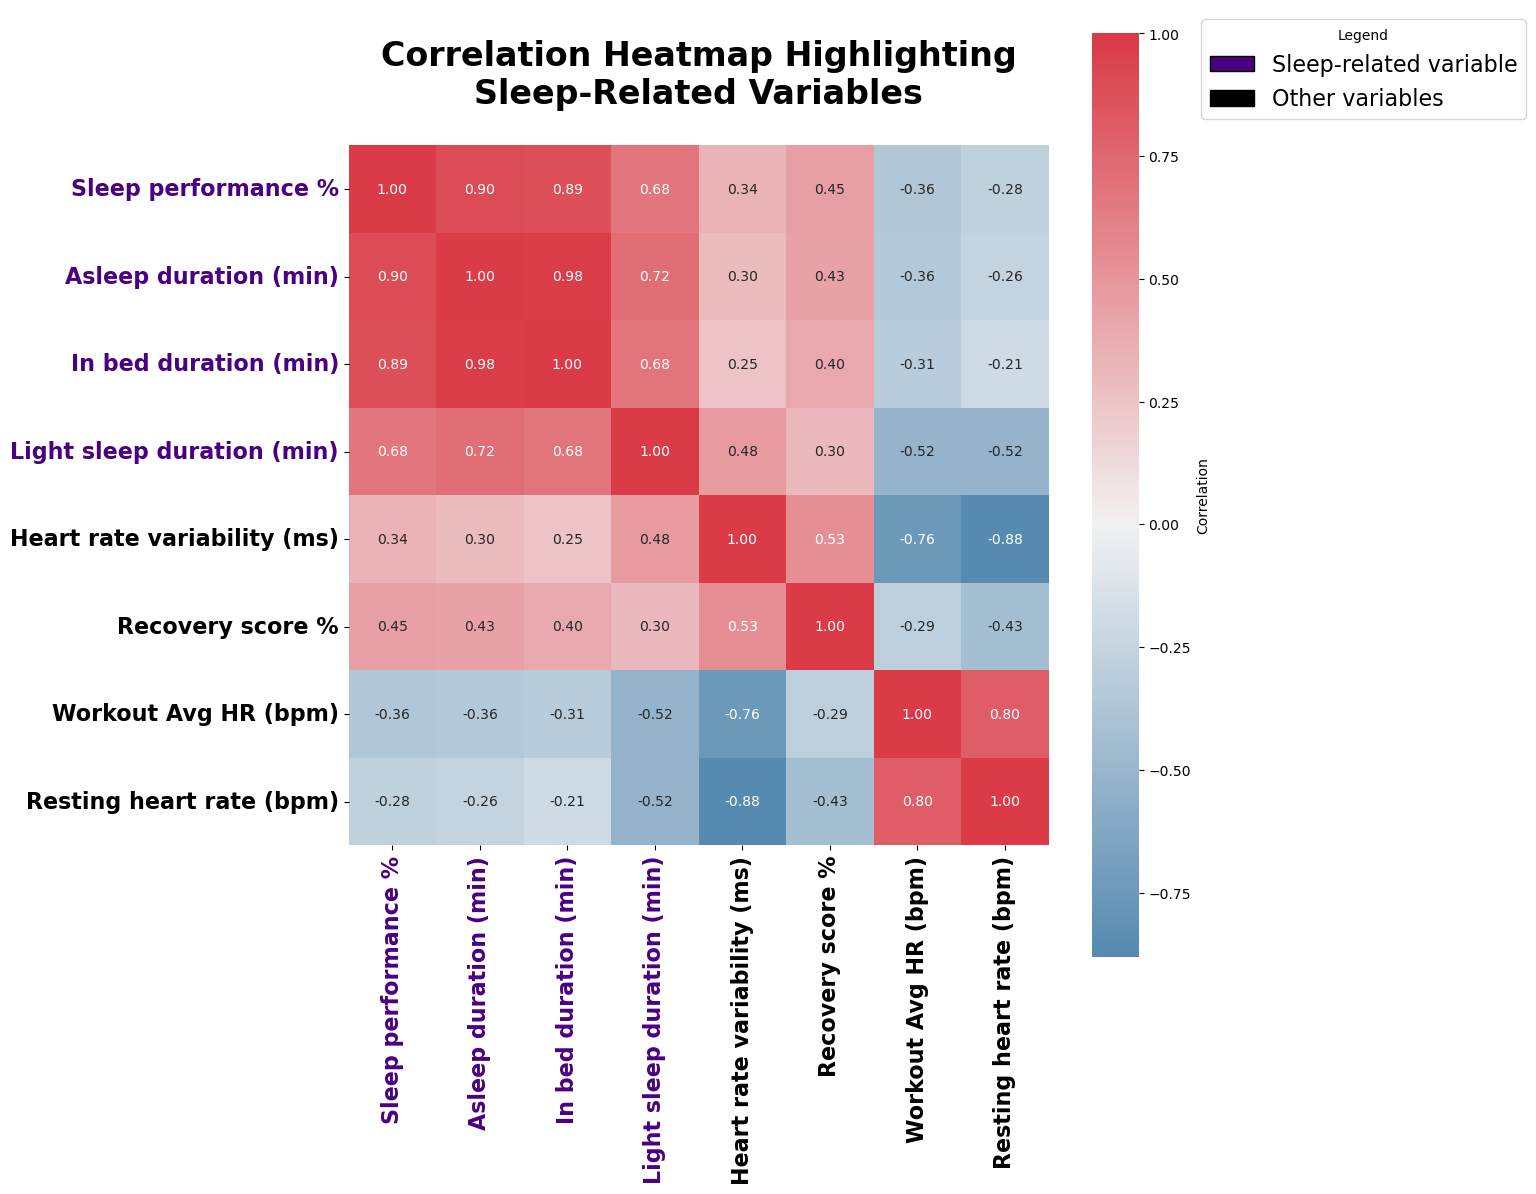

In [7]:
# get a custom colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# get what we want to see from above
sleep_features = pd.unique(sleep_corrs_filtered[['Feature 1', 'Feature 2']].values.ravel())
sleep_corr_matrix = merged_clean[sleep_features].corr()


# sort the variables to put the sleep variables together

ordered_features = [feat for feat in sleep_targets if feat in sleep_features] + \
                   [feat for feat in sleep_features if feat not in sleep_targets]
sleep_corr_matrix = sleep_corr_matrix.loc[ordered_features, ordered_features]

# plot the heatmap
fig, ax = plt.subplots(figsize=(14, 12))
heatmap = sns.heatmap(sleep_corr_matrix,cmap=cmap,annot=True,fmt=".2f",center=0,
                      square=True,cbar_kws={'label': 'Correlation'},ax=ax)

# color the axis labels: sleep purple, vs other variables
for label in ax.get_xticklabels():
    label_text = label.get_text()
    label.set_color('#4B0082' if label_text in sleep_targets else 'black')
    label.set_fontweight('bold')
    label.set_fontsize(16)
    
for label in ax.get_yticklabels():
    label_text = label.get_text()
    label.set_color('#4B0082' if label_text in sleep_targets else 'black')
    label.set_fontweight('bold')
    label.set_fontsize(16)

# add title with spacing
ax.set_title('Correlation Heatmap Highlighting\nSleep-Related Variables',
             fontsize=24,fontweight='bold',pad=30)

# move plot to left to get some legend space
plt.subplots_adjust(right=0.75)
legend_elements = [Patch(facecolor='#4B0082', edgecolor='black', label='Sleep-related variable'),
                   Patch(facecolor='black', edgecolor='black', label='Other variables')]
legend_ax = fig.add_axes([0.75, 0.80, 0.2, 0.1])
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='center', title='Legend', frameon=True, prop={'size': 16} )
plt.savefig('graph1.png', dpi=300, bbox_inches='tight')
plt.show()



**Insights from the Heatmap to Explore**

Resting heart rate and workout intensity are negatively correlated with light sleep duration — suggesting physiological stress may reduce lighter sleep phases.

**Why Light Sleep Is Important**
https://www.whoop.com/us/en/thelocker/what-is-light-sleep-why-its-important/?srsltid=AfmBOoqi0uyKV-1LaQXLTUiwE6rD6mK8NQfnq3LTCObX21KtiXCLS1rh

Although light sleep doesn’t sound restful, that’s not the case. It is the point where your muscles relax, your body temperature decreases, and your brain waves begin slowing. As brain activity slows during light sleep we experience short bursts of activity that help us resist being woken up by external stimuli. Light sleep suppresses our senses and prevents us from moving so we can remain asleep. It’s also important for memory, learning and motor skills. Getting sufficient light sleep is essential to meeting your overall sleep needs. Chronic sleep deprivation is associated with high blood pressure and heart disease, as well as obesity, depression and problems with your immune system. Without adequate sleep we may find ourselves unable to process new information or learn new skills and we lose the ability to access previously learned information. We can also suffer from poor judgement and lose the ability to assess situations, plan and choose behaviors.  

### Figure 2

In [8]:
# Make a copy of the dataset
df = merged_clean.copy()

# Ensure all interval columns are converted to strings
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, pd._libs.interval.Interval)).any():
        df[col] = df[col].astype(str)

# Create a slider for Recovery Score %
recovery_slider = alt.binding_range(min=0, max=100, step=1, name='Recovery Score %: ')
recovery_param = alt.param(name='RecoveryFilter', bind=recovery_slider, value=50)

# Base chart for filtering
base = alt.Chart(df).transform_filter(
    (alt.datum['Recovery score %'] >= recovery_param - 5) & 
    (alt.datum['Recovery score %'] <= recovery_param + 5)
).add_params(
    recovery_param
)

# Chart 1: Resting Heart Rate vs Light Sleep Duration
chart1 = base.mark_circle(opacity=0.7).encode(
    x=alt.X('Resting heart rate (bpm):Q', 
            title='Resting Heart Rate (bpm)', 
            scale=alt.Scale(domain=[25, 100]),
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    y=alt.Y('Light sleep duration (min):Q', 
            title='Light Sleep Duration (min)', 
            scale=alt.Scale(domain=[0, 500]),
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    color=alt.Color('Recovery score %:Q', scale=alt.Scale(scheme='tealblues'), legend=alt.Legend(title='Recovery Score %')),
    tooltip=['Resting heart rate (bpm)', 'Light sleep duration (min)', 'Recovery score %']
).properties(
    title='Resting Heart Rate (RHR) and Light Sleep Duration',
    width=550,
    height=400
)

# Chart 2: HRV vs Light Sleep Duration
chart2 = base.mark_circle(opacity=0.7).encode(
    x=alt.X('Heart rate variability (ms):Q', 
            title='Heart Rate Variability (HRV)', 
            scale=alt.Scale(domain=[0, 130]),
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    y=alt.Y('Light sleep duration (min):Q', 
            title='Light Sleep Duration (min)', 
            scale=alt.Scale(domain=[0, 500]),
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    color=alt.Color('Recovery score %:Q', scale=alt.Scale(scheme='tealblues'), legend=None),
    tooltip=['Heart rate variability (ms)', 'Light sleep duration (min)', 'Recovery score %']
).properties(
    title='Heart Rate Variability (HRV) and Light Sleep Duration',
    width=550,
    height=400
)

# Combine the two charts side by side
combined_chart = alt.hconcat(chart1, chart2).resolve_scale(
    color='independent'
).configure_title(
    fontSize=24,
    anchor='start'
)

combined_chart.save('graph2.html')
combined_chart

alt.HConcatChart(...)

Calculate % of total sleep time spent in each stage
Classify each stage into:
Low (below normal range)
Normal (within healthy range)
High (above normal range)
https://my.clevelandclinic.org/health/body/12148-sleep-basics?utm_source=chatgpt.com



### Figure 3
Create and save data for d3 plot

In [9]:
# get total sleep time
merged_clean['Total Sleep'] = merged_clean['Asleep duration (min)']

# calculate percentage of total sleep for each stage
merged_clean['REM %'] = merged_clean['REM duration (min)'] / merged_clean['Total Sleep'] * 100
merged_clean['Deep %'] = merged_clean['Deep (SWS) duration (min)'] / merged_clean['Total Sleep'] * 100
merged_clean['Light %'] = merged_clean['Light sleep duration (min)'] / merged_clean['Total Sleep'] * 100

# classify percent in each stage based on norms
def classify_rem(p):
    if p < 20:
        return 'Below Normal (<10%)'
    elif p > 25:
        return 'Above Normal (>30%)'
    else:
        return 'Normal (10–30%)'

def classify_deep(p):
    if p < 13:
        return 'Below Normal (<10%)'
    elif p > 23:
        return 'Above Normal (>20%)'
    else:
        return 'Normal (10–20%)'

def classify_light(p):
    if p < 45:
        return 'Below Normal (<40%)'
    elif p > 55:
        return 'Above Normal (>60%)'
    else:
        return 'Normal (40–60%)'

# now apply classification
merged_clean['REM'] = merged_clean['REM %'].apply(classify_rem)
merged_clean['Deep (SWS)'] = merged_clean['Deep %'].apply(classify_deep)
merged_clean['Light sleep'] = merged_clean['Light %'].apply(classify_light)

In [10]:
# make each group have same label
def get_group_type(label):
    if 'Below' in label:
        return 'Below Normal'
    elif 'Above' in label:
        return 'Above Normal'
    else:
        return 'Normal'

# melt into long format
group_long = pd.melt(
    merged_clean,
    id_vars=['Heart rate variability (ms)'],
    value_vars=['REM', 'Deep (SWS)', 'Light sleep'],
    var_name='Sleep Stage',
    value_name='Group Label'
)

# add labels for each group and remove space in column names
group_long['Group Type'] = group_long['Group Label'].apply(get_group_type)
group_long.columns = group_long.columns.str.replace(' ', '_')


# save to new file for d3 graph
# group_long.to_csv('d3_data_.csv', index=False)


### Figure 4
**Working Out and Sleep**

What happens to each sleep stage if someone spends a fixed amount of time — like 10 minutes — in a specific heart rate zone?

In [11]:
# get minutes in each HR Zone using % and Activity Duration
for i in range(1, 6):
    merged_clean[f'HR Zone {i} min'] = (
        merged_clean[f'HR Zone {i} %'] / 100
    ) * merged_clean['Activity Duration (min)']

# make "target range" for each zone
zone_ranges = {
    f'Zone {i}': merged_clean[
        (merged_clean[f'HR Zone {i} min'] >= 9) & 
        (merged_clean[f'HR Zone {i} min'] <= 11)
    ]
    for i in range(1, 6)
}

# show average sleep stage durations for each zone
summary_list = []

for zone_name, df_subset in zone_ranges.items():
    sleep_means = df_subset[[
        'REM duration (min)',
        'Deep (SWS) duration (min)',
        'Light sleep duration (min)'
    ]].mean()

    for stage, value in sleep_means.items():
        summary_list.append({
            'Zone': zone_name,
            'Sleep Stage': stage.replace(' duration (min)', ''),
            'Avg Duration (min)': value
        })

# make in to DataFrame and standardize names
zone_impact_df = pd.DataFrame(summary_list)
zone_impact_df['Sleep Stage'] = zone_impact_df['Sleep Stage'].replace({
    'Deep (SWS)': 'Deep',
    'Light sleep': 'Light'
})
zone_impact_df.head()


,Zone,Sleep Stage,Avg Duration (min)
0,Zone 1,REM,86.180851
1,Zone 1,Deep,87.117021
2,Zone 1,Light,246.627660
3,Zone 2,REM,87.677083
4,Zone 2,Deep,84.656250


In [12]:
selection = alt.selection_point(
    fields=['Sleep Stage'],
    bind=alt.binding_select(options=list(zone_impact_df['Sleep Stage'].unique()), name='Sleep Stage: '),
    value='REM'
)

palette={'REM': '#1A5276','Deep': '#5499C7','Light': '#A9CCE3' }

# Create the interactive bar chart with dropdown
zone_chart = alt.Chart(zone_impact_df).mark_bar(
    size=60
).encode(
    x=alt.X('Zone:N', 
            title='Heart Rate Zone',
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    y=alt.Y('Avg Duration (min):Q', 
            title='Average Duration (minutes)', 
            scale=alt.Scale(domain=[0, 300]),
            axis=alt.Axis(labelFontSize=16, titleFontSize=16)),
    color=alt.Color('Sleep Stage:N', scale=alt.Scale(domain=list(palette.keys()), range=list(palette.values()))),
    tooltip=['Avg Duration (min)']
).properties(
    title='Average Sleep Duration by Zone and Sleep Stage',
    width=650,
    height=450
).add_params(
    selection
).transform_filter(
    selection
).configure_title(
    fontSize=24
)

zone_chart.save('graph4.html')
zone_chart

alt.Chart(...)

### Figure 5
Build a Random Forest model to predict REM, Deep, and Light sleep duration from Zone 5 cardio time

In [13]:
# get rows w/ Zone 5 cardio
df_zone5 = merged_clean[merged_clean['HR Zone 5 min'] > 0].copy()

X = df_zone5[['HR Zone 5 min']] 

In [14]:
# fit the model
forest_models = {}
zone5_range = np.arange(0, 51, 1).reshape(-1, 1) 

for target in ['REM duration (min)', 'Deep (SWS) duration (min)', 'Light sleep duration (min)']:
    y = df_zone5[target]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    y_pred = rf.predict(zone5_range)
    
    forest_models[target] = {
        'model': rf,
        'zone5_range': zone5_range.flatten(),
        'predicted': y_pred
    }

/opt/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


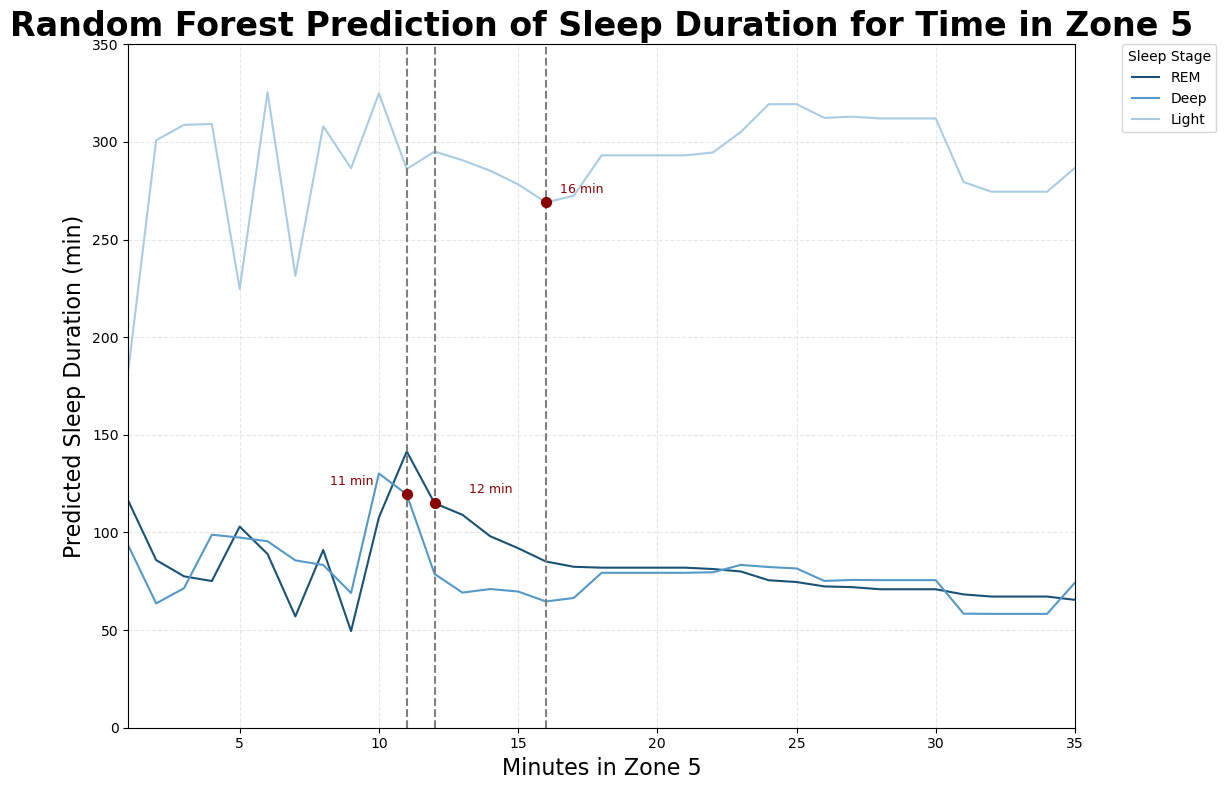

In [15]:
# make the time in optimal sleep durations
optimal_sleep = {
    'REM duration (min)': 120,
    'Deep (SWS) duration (min)': 110,
    'Light sleep duration (min)': 270}

colors = {
    'REM duration (min)': '#1A5276',
    'Deep (SWS) duration (min)': '#5499C7',
    'Light sleep duration (min)': '#A9CCE3'
}

plt.figure(figsize=(14, 8))

# make lines
for target, result in forest_models.items():
    plt.plot(
        result['zone5_range'],
        result['predicted'],
        label=target.split()[0],
        color=colors[target])

# make the red dots at Zone 5 minutes that are when there is the optimal durations of sleep
for stage, optimal_y in optimal_sleep.items():
    result = forest_models[stage]
    mask = result['zone5_range'] >= 1.5
    x_vals = result['zone5_range'][mask]
    predicted = result['predicted'][mask]

    # get closest predicted sleep to optimal durations
    closest_idx = np.argmin(np.abs(predicted - optimal_y))
    x = x_vals[closest_idx]
    y = predicted[closest_idx]

    # make red dot and line
    plt.scatter(x, y, color='darkred', s=50, zorder=5)
    plt.axvline(x=x, linestyle='--', color='gray')

    # include labels
    if 'Deep' in stage:
        plt.text(x - 1.2, y + 5, f'{int(x)} min', fontsize=9, color='darkred', ha='right')
    elif 'REM' in stage:
        plt.text(x + 2, y + 5, f'{int(x)} min', fontsize=9, color='darkred', ha='center')
    else:
        plt.text(x + 0.5, y + 5, f'{int(x)} min', fontsize=9, color='darkred', ha='left')

# format
plt.title('Random Forest Prediction of Sleep Duration for Time in Zone 5', fontweight='bold', fontsize=24)
plt.xlabel('Minutes in Zone 5', fontsize=16)
plt.ylabel('Predicted Sleep Duration (min)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(left=1, right=35)
plt.ylim(bottom=0, top=350)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('graph5.png', dpi=300, bbox_inches='tight')
plt.show()

